## Analysis of a Word Generator Using an SVM Classifier
### Jeremy Miesch

This project has two goals:

1. Create a word generator that uses bigram proportions in a corpus to generate fake words that resemble words of an input language.

2. Classify these words using an SVM Classifier and evaluate the FScore.

The motivation for the project is to have a tool to generate many fake words that are consistent with many differenct languages. More specifically, I am a Dungeon Master for the tabletop game Dungeons and Dragons, and I can use this to generate place and people names. If, say, I think a tribe of goblins will speak a language somewhat similar to French, I can use this generator to create fake French-sounding words.

## Data

- eng.txt: english corpus extracted from project Gutenberg, War and Peace
https://www.gutenberg.org/ebooks/2600 

- pol.txt: polish corpus extracted from scrabble words dataset on Github: https://raw.githubusercontent.com/turekj/msc/master/CheatAR/development/server/word-dictionary-importer/src/main/resources/scrabble-polish-words.txt

- mal.txt: malay corpus extracted from malay common words dataset on Kaggle: https://www.kaggle.com/datasets/imroze/indonesian-and-malaysian-common-words-list

- fra.txt: french corpus extracted from french wordlish on Github: https://github.com/Taknok/French-Wordlist/blob/master/francais.txt


In [1]:
# Import packages

import numpy as np
import random
import string
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.feature_extraction import DictVectorizer
from sklearn import svm 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os

## Part One: Word Generator

In [2]:
# process_word function
#  input: word - raw text word
#  output: processed word

def process_word (word):
    
    processed = ""
    
    # check if char is punctuation, uppercase, or in a select list of characters that wer giving me trouble
    for char in word:
        if char not in string.punctuation and char not in ["”","“","’",'1','2','3','4','5','6','7','8','9','á','™','—']:
            processed += char.lower()
            
    return "<" + processed + ">"

In [3]:
# read_file function
#  input: file - file name of corpus
#  outpt: bigrams_dict - dictionary of all bigram frequencies in the corpus

def read_file(file):
    lines = [line.strip() for line in open(file)]

    bigrams = defaultdict(int)

    for line in lines:
        for word in line.split(' '):
            
            # process word
            word = process_word(word)

            # check size then add bigram to dictionary
            if len(word) > 2:
                for x in range(len(word)-1):
                    bigrams[word[x]+word[x+1]] += 1

    # get oercentages
    num_bigrams = sum(list(bigrams.values()))
    bigrams_dict = {x: bigrams[x] / num_bigrams for x in bigrams}
    
    return bigrams_dict

In [4]:
# let_prop function
#  input: letter - given letter, bigrams - bigram dictionary of corpus
#  output: let_prop_norm - probabilities of letter following input, given as a dict

def let_prop(letter,bigrams):
    let_prop_dict = {}
    
    for x in bigrams:
        if x[:len(letter)] == letter:
            let_prop_dict[x[1:]] = bigrams[x]
    
    # normalize
    let_sum = sum(list(let_prop_dict.values()))
    let_prop_norm = {x: let_prop_dict[x] / let_sum * 100 for x in list(let_prop_dict.keys())}

    return let_prop_norm

In [5]:
# generate_word function
#  input: bigrams - bigram dictionary of corpus, max_lets - maximum number of letters
#  output: word - generated word

def generate_word(bigrams,max_lets=15):
    
    vows = "aeiou"
    
    nextt = let_prop("<",bigrams)
    
    word = "<"
    
    next_let = random.choices(list(nextt.keys()), weights = list(nextt.values()),k=1)[0]
    word += next_let
    
    # loop until stop character or max_lets reached; make sure there is at least one vowel
    i = 0
    num_vows = 0
    while i < max_lets and word[-1] != ">" or num_vows == 0:
        nextt = let_prop(next_let,bigrams)   
        
        next_let = random.choices(list(nextt.keys()), weights = list(nextt.values()),k=1)[0]
        
        while next_let == ">" and num_vows == 0:
            next_let = random.choices(list(nextt.keys()), weights = list(nextt.values()),k=1)[0]
            #print(next_let)
        
        if next_let not in vows and next_let != ">":
            if word[-1] in vows or (len(word) > 3 and word[-2] in vows):
                word += next_let
        
        elif next_let in vows:
            num_vows += 1
            word += next_let
            
        elif next_let == ">":
            word += next_let
        
        i += 1
    
    # add stop character if not present
    if word[-1] != ">":
        word += ">"
    
    return word

## Part Two: Classification

In [6]:
# get_word_list function
#  input: the_file - file name
#  output: words - list of word in the file


def get_word_list (the_file):
    lines = [line.strip() for line in open(the_file,errors='ignore')]
    words = []
    
    for line in lines:  
        for word in line.split(' '):
            words.append(process_word(word)[1:-1])
    
    random.shuffle(words)
    
    return words

In [7]:
# featurizer function:
#  input: word 
#  output: feats - list of features of the given word (length, last 3 letters)

def featurizer(word):
    feats = [len(word)]
    
    if len(word) > 0:
        feats.append(word[-1])
    else:
        feats.append(word)
        
    if len(word) > 1:
        feats.append(word[-2:])
    else:
        feats.append(word)
    
    return feats

In [8]:
# get_feats function:
#  input: word_list - list of words in a corpus
#  output: feats - features of all words in the word_list

def get_feats(word_list):
    feats = list(set(np.array([featurizer(x) for x in word_list]).flatten()))
    return feats

In [9]:
# get_feat function
#  input: word - given word, feats - feat list of corpus (from get_feats)
#  output: feats_bin - binary representation of each word

def get_feat(word, feats):
    word_feats = featurizer(word)
    feats_bin = [0] * len(feats)

    for y in word_feats:
        if y in feats:
            feats_bin[feats.index(y)] = 1
    
    return feats_bin

In [10]:
# word_list_to_feat_list function
#  input: word_list - word list of a corpus, lang - language of the word list
#  output: binar - list of tuples with language label and list of binary features for every word in word list

def word_list_to_feat_list(word_list,lang):
    
    feats = get_feats(word_list)
    
    binar = [(lang, get_feat(x, feats)) for x in word_list]
            
    return binar

In [11]:
# feat_list_to_dict function
#  input: feats - list of all binary features of a word list, from word_list_to_feat_list()
#  output: dictionary of features to be used by vectorizer

def feat_list_to_dict(feats):
    return {x : feats[x] for x in range(len(feats))}

In [12]:
# read_files function
#  input: none
#  output: list of all featurized words in all the folders

def read_files():
    directory = r"data"

    # loop through data directory
    bin_list = []
    for name in os.listdir(directory):
    
        # checks for hidden folders in macOS - I was having an issue with them
        if name[0] != '.':
    
            direc = directory + "/" + name

            # append word feat representations to bin_list
            bin_list.append(word_list_to_feat_list(get_word_list(direc),name[:3]))
     
    # flatten bin_list into one list
    all_lists = []
    for x in bin_list:
        for y in x:
            all_lists.append(y)
        
    return all_lists

In [ ]:
# read files
train = read_files()

In [ ]:
# get classes (languages) and feature dict
classes,feat_dict_list = zip(*[(x[0],feat_list_to_dict(x[1])) for x in train])

In [ ]:
# train classifier

vectorizer = DictVectorizer(sparse = True)
X = vectorizer.fit_transform(feat_dict_list)

clf = svm.LinearSVC()
clf.fit(X,classes)

In [27]:
# fscore function
#  input: tp - true positives, fp - false positives, fn - false negatives
#  output: fscore

def fscore (tp,fp,fn):
    return tp / (tp + 0.5 * (fp + fn))

In [40]:
# test_langs function
#  input: langs list of languages to test
#  output: shows confusion matrix, prints f score

def test_langs(langs):
    
    test_l = []
    for lang in langs:
    
        # get all bigrams of each language
        file = "data/" + lang + ".txt"
        bigrams = read_file(file)

        # generate 1000 words of using the bigram dict
        test_list = [generate_word(bigrams,10) for x in range(5000)]
        
        # transfer word list to features
        test = word_list_to_feat_list(test_list,lang)
        
        test_l.append(test)

    # flatten the list
    test_l_flat = []
    for x in test_l:
        test_l_flat += x
        
    # create dictionary from the list of all features
    test_feat_dict_list = [feat_list_to_dict(x[1]) for x in test_l_flat]
    
    # use model to predict labels
    guesses = clf.predict(vectorizer.transform(test_feat_dict_list))
    correct = [x[0] for x in test_l_flat]
    
    cm = confusion_matrix(correct, guesses, labels=langs)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=langs)
    disp.plot()
    plt.show()
    
    # find true postives, false positives, and false negatives for fscore
    tp = 0
    fp = 0
    fn = 0
    for gu, co in zip(guesses,correct):
        if gu == co:
            tp += 1
        elif gu != lang:
            fn += 1
        elif co != lang:
            fp += 1

    print("F Score for generated words of " + ",".join(langs) + " : " + str(fscore(tp,fp,fn)))
    print()

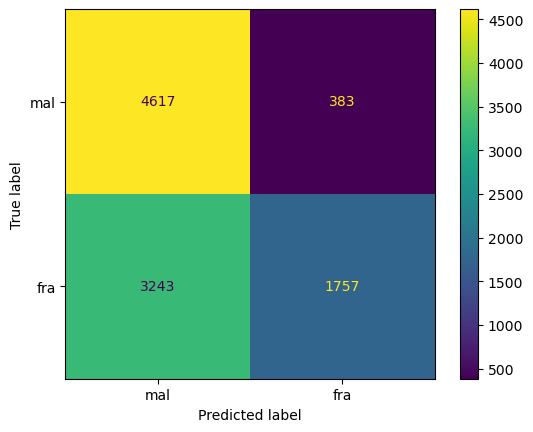

F Score for generated words of mal,fra : 0.7785513619152314



In [41]:
test_langs(["mal","fra"])

## Final Thoughts

Unfortunately, I did not have the processing power to run any more than two languages at a time. My kernel kept dying otherwise.

The two languages I am submitting are from my French and Malay corpuses. I chose these because, while both languages typically use the roman alphabet, they are pretty distinct phonetically. This resulted in the best f scores. 

Even with these two languages, the f score was not very high (the max I saw it get was around 81%). With more time, I could improve the word generator by adding more syllabic features, as well as potentially implementing an LSTM model.

The f scores were high enough to warrant some success, however.